In [191]:
from torch import nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
import torch


In [192]:
import torch.nn as nn

class TitanicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 32),   # Increase hidden units for more capacity
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)     # Output raw logits
        )

    def forward(self, x):
        return self.net(x)  # No sigmoid here, use BCEWithLogitsLoss later


In [193]:
import torch.nn as nn

class TitanicModel(nn.Module):
   def __init__(self,feature_len):
        super().__init__()
        self.layers= nn.Sequential(
        nn.Linear(feature_len, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(32, 16),
        nn.ReLU(),

        nn.Linear(16, 1),
    
        )
   def forward(self,x,y=None):
       return self.layers(x)  
 

In [194]:
from fastai.learner import Learner
from fastai.metrics import accuracy
from fastai.losses import CrossEntropyLossFlat  # for classification




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load Titanic dataset (replace with your path or URL)
df = pd.read_csv('Titanic-Dataset.csv')

# 1. Select features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = df[features]
y = df[target]

# 2. Define preprocessing for numeric features
numeric_features = ['SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing with median
    ('scaler', StandardScaler())])                   # Scale to zero mean, unit variance

# 3. Define preprocessing for categorical features
categorical_features = ['Pclass', 'Sex', 'Embarked']
# Bin 'Age' into categories before categorical_transformer
# We'll add a new feature 'AgeBin' to X and treat it as categorical

# Bin Age into 5 bins (you can adjust bins as needed)
X['AgeBin'] = pd.cut(X['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

X['IsFirstClass'] = (X['Pclass'] == 1).astype(int)

# 2. Create a new feature: IsThirdClass (1 if Pclass==3 else 0)
X['IsThirdClass'] = (X['Pclass'] == 3).astype(int)

# 3. Create an interaction feature: FarePerClass (Fare divided by Pclass)
X['FarePerClass'] = X['Fare'] / X['Pclass']

# 4. (Optional) One-hot encode Pclass if not already done
# This is often handled by the categorical transformer, but you can do it manually if needed:
# X = pd.get_dummies(X, columns=['Pclass'], prefix='Pclass')

# Remember to add any new features to your feature lists for preprocessing:
numeric_features += ['FarePerClass']


# Add 'AgeBin' to categorical features
categorical_features = [ 'Sex', 'Embarked', 'AgeBin']
categorical_features += ['IsFirstClass', 'IsThirdClass']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])   # One-hot encode categories
# 4. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 5. Apply preprocessing to features
X_processed = preprocessor.fit_transform(X)

# 6. Optional: Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

print(f"Training samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")


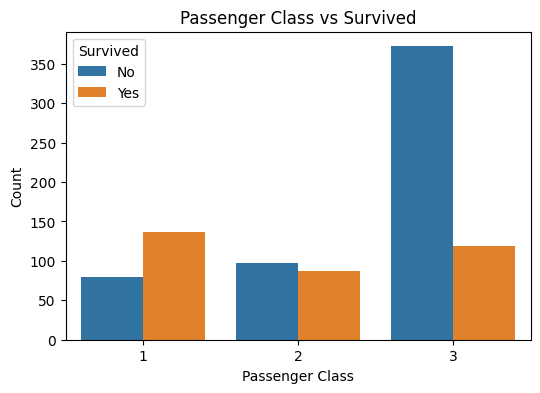

/var/folders/xs/kqvv4_bx2dx9hby123kgmhsm0000gn/T/ipykernel_15123/1137574374.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['IsFirstClass'] = (X['Pclass'] == 1).astype(int)
/var/folders/xs/kqvv4_bx2dx9hby123kgmhsm0000gn/T/ipykernel_15123/1137574374.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['IsThirdClass'] = (X['Pclass'] == 3).astype(int)
/var/folders/xs/kqvv4_bx2dx9hby123kgmhsm0000gn/T/ipykernel_15123/1137574374.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

<Figure size 640x480 with 0 Axes>

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Passenger Class vs Survived
plt.figure(figsize=(6,4))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Passenger Class vs Survived')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

# --- Feature Engineering Suggestion for Passenger Class ---

# 1. Create a new feature: IsFirstClass (1 if Pclass==1 else 0)
X['IsFirstClass'] = (X['Pclass'] == 1).astype(int)

# 2. Create a new feature: IsThirdClass (1 if Pclass==3 else 0)
X['IsThirdClass'] = (X['Pclass'] == 3).astype(int)
import io
import mlflow

# Save the plot to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# Log the plot as an artifact in mlflow
mlflow.set_experiment("experiment_one")
with mlflow.start_run():
    mlflow.log_figure(plt.gcf(), "passenger_class_vs_survived.png")

buf.close()



In [198]:
from torch.utils.data import Dataset, DataLoader

In [199]:
class TitanicDataset(Dataset):
    def __init__(self,x,y) -> None:
        super().__init__()
        self.x= torch.from_numpy(x).float()
        self.y = torch.from_numpy(y.values).float().unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]  # ✅ tuple, not dict
 

In [200]:
from torch.utils.data import random_split

train_ds = TitanicDataset(x_train, y_train)
valid_ds = TitanicDataset(x_test, y_test)


train_dl = DataLoader(train_ds, batch_size=5)
valid_dl = DataLoader(valid_ds, batch_size=5)

from fastai.data.core import DataLoaders
dls = DataLoaders(train_dl, valid_dl)


In [201]:

model = TitanicModel(18)

In [253]:
import mlflow
import mlflow.pytorch
from datetime import datetime

mlflow.set_experiment("experiment_one")
run_name = f"Titanic_Torch_Run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

with mlflow.start_run(run_name=run_name):
    mlflow.log_param("batch_size", 5)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("learning_rate", 1e-3)
    mlflow.log_param("model_architecture", model)

    learn = Learner(dls, model, loss_func=nn.BCEWithLogitsLoss(), metrics=accuracy)
    learn.fit(2, lr=1e-3)

    # Log metrics to mlflow
    # Get predictions and targets on validation set
    preds, targets = learn.get_preds(dl=valid_dl)
    probs = preds.sigmoid()
    pred_classes = (probs > 0.5).int()

    # Convert torch tensors to numpy arrays for sklearn
    y_true = targets.numpy().astype(int).flatten()
    y_pred = pred_classes.numpy().flatten()

    from sklearn.metrics import accuracy_score, roc_auc_score

    val_acc = accuracy_score(y_true, y_pred)
    val_auc = roc_auc_score(y_true, probs.numpy().flatten())

    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.log_metric("val_auc", val_auc)
    # Register the trained model in MLflow with input_example for signature inference
    import torch
    # Create a dummy input example matching the model's input shape (batch_size=1, features=18)
    # Use a numpy array for input_example, as required by mlflow
    import numpy as np
    input_example = np.random.randn(1, 18).astype(np.float32)
    mlflow.pytorch.log_model(model, "model", input_example=input_example)

print(run_name)   


[0, 0.2393595576286316, 0.504589855670929, 0.5865921974182129, '00:02']
[1, 0.2603432536125183, 0.4941646158695221, 0.5865921974182129, '00:01']


2025/06/27 18:04:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 18:04:21 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Tensor for argument input is on cpu but expected on mps'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2025/06/27 18:04:28 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      1.654295563697815,
      -0.1138170063495636,
      -1.3460477590560913,
      1.5252264738082886,
      0.553064227104187,
      -0.027216516435146332,
      -0.0976099818944931,
      0.12716233730316162,
      -0.20885372161865234,
      -0.8586437106132507,
      -0.13900865614414215,
      -1.5313117504119873,
      1.76656973361969,
      1.269761562347412,
      1.7213680744171143,
      -1.3120931386947632,
      0.653991162776947,
      -1.58901870250

Titanic_Torch_Run_20250627_180417


Validation Accuracy: 0.8398876404494382
Best threshold by Youden's J statistic: 0.4077
At this threshold: TPR=0.8116, FPR=0.1743


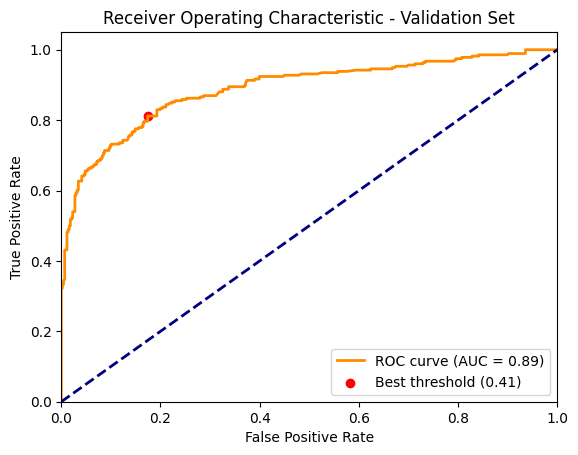

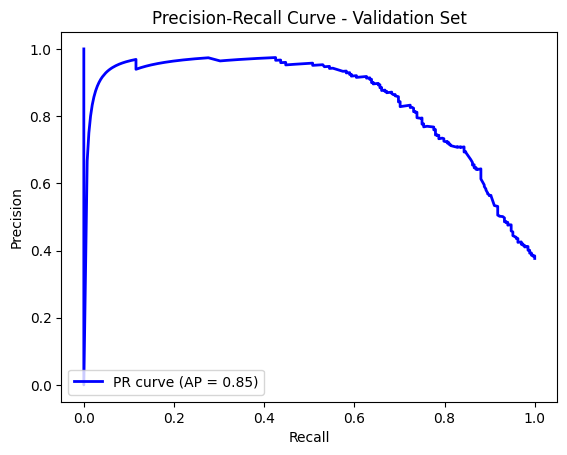

In [185]:
# Get predictions and targets on validation set
preds, targets = learn.get_preds(dl=train_dl)

# preds are raw logits, convert to probabilities
probs = preds.sigmoid()

# Convert probabilities to binary classes (0 or 1)
pred_classes = (probs > 0.5).int()
from sklearn.metrics import accuracy_score

# Convert torch tensors to numpy arrays for sklearn
y_true = targets.numpy().astype(int).flatten()
y_pred = pred_classes.numpy().flatten()

acc = accuracy_score(y_true, y_pred)
print("Validation Accuracy:", acc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# fpr stands for "False Positive Rate" and tpr stands for "True Positive Rate".
# 
# - False Positive Rate (fpr): This is the proportion of actual negatives that are incorrectly classified as positives. 
#   It is calculated as: fpr = FP / (FP + TN), where FP is the number of false positives and TN is the number of true negatives.
#
# - True Positive Rate (tpr): This is also known as "Recall" or "Sensitivity". It is the proportion of actual positives that are correctly identified.
#   It is calculated as: tpr = TP / (TP + FN), where TP is the number of true positives and FN is the number of false negatives.
#
# In the context of the ROC curve, fpr and tpr are computed at various threshold settings to evaluate the performance of a binary classifier.
# The "best" threshold on the ROC curve depends on your specific goal (e.g., maximizing accuracy, recall, or balancing both).
# A common approach is to choose the threshold that gives the best balance between true positive rate (tpr) and false positive rate (fpr).
# One way to do this is to maximize the Youden's J statistic: J = tpr - fpr

# Find the threshold that maximizes tpr - fpr
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_threshold = thresholds[best_idx]
print(f"Best threshold by Youden's J statistic: {best_threshold:.4f}")
print(f"At this threshold: TPR={tpr[best_idx]:.4f}, FPR={fpr[best_idx]:.4f}")

# Optionally, plot the chosen threshold on the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision
precision, recall, pr_thresholds = precision_recall_curve(y_true, probs.numpy().flatten())
avg_precision = average_precision_score(y_true, probs.numpy().flatten())

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Validation Set')
plt.legend(loc="lower left")
plt.show()



# ## ROC-AUC vs. Precision-Recall Curve
# 
# ROC-AUC shows the trade-off between true positive rate (recall) and false positive rate. Best for balanced classes.
# 
# Precision-Recall curve shows precision vs. recall. More useful for imbalanced datasets or when the positive class is rare.
# 
# **Summary:**
# - Use ROC-AUC for balanced classes.
# - Use Precision-Recall for imbalanced or rare positive class.
# 
# **Key Metrics:**
# - **Precision:** TP / (TP + FP)
# - **Recall (TPR):** TP / (TP + FN)
# - **FPR:** FP / (FP + TN)
# 
# Precision and recall are especially important for imbalanced data. TPR = Recall. FPR focuses on negatives.


In [115]:
from sklearn.ensemble import RandomForestClassifier

In [116]:
tree_model=RandomForestClassifier(10)

In [123]:
tree_model.fit(x_train,y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred=tree_model.predict(x_test)

In [135]:
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,roc_curve

In [128]:
accuracy_score(y_pred,y_test)

0.8100558659217877

In [ ]:
accuracy_score(pred_classes, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [712, 179]

In [ ]:
pred_classes

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [141]:
preds

tensor([[-2.1236],
        [ 2.0507],
        [-2.9228],
        [-2.6414],
        [-3.4986],
        [-2.1654],
        [-2.1132],
        [ 0.2524],
        [ 3.3372],
        [ 1.0842],
        [-2.1767],
        [-1.4021],
        [ 2.6560],
        [ 2.3711],
        [-0.0113],
        [-0.2951],
        [-2.1808],
        [-0.8598],
        [-1.7705],
        [ 2.6200],
        [-1.8854],
        [-2.4227],
        [-2.7643],
        [-0.2169],
        [-2.1056],
        [ 0.4154],
        [-1.1997],
        [-0.3773],
        [ 2.6773],
        [-2.5224],
        [-0.3322],
        [-0.8701],
        [ 3.1730],
        [-2.3244],
        [ 1.4592],
        [-2.0719],
        [ 1.1102],
        [ 0.5266],
        [ 3.8261],
        [-2.0784],
        [-2.0654],
        [ 1.6231],
        [-2.1817],
        [-2.6171],
        [ 2.9807],
        [-2.6936],
        [-3.4249],
        [-0.2338],
        [-2.4802],
        [-2.0698],
        [-2.0748],
        [-0.0620],
        [-2.

In [133]:
roc_auc_score(y_pred,y_test)

0.8069687334393217

In [136]:
roc_curve(y_pred,y_test)

(array([0.        , 0.18018018, 1.        ]),
 array([0.        , 0.79411765, 1.        ]),
 array([inf,  1.,  0.]))

In [137]:
confusion_matrix(y_test,y_pred)

array([[91, 14],
       [20, 54]])

In [138]:
confusion_matrix(target,preds)

InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got 'Survived' instead.

'Survived'